In [1]:
%reload_ext autoreload

In [2]:
%autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mvlearn.embed import MCCA
import umap

from sklearn.decomposition import PCA

from IPython.display import clear_output

import sys
sys.path.append("..")

from src.mofa_utils import train_mofa
from src.tcga_preprocess_utils import split_patients_for_target_prediction
from src.constants import RANDOM_STATE
from src.pipelines import regression_pipeline_gdsc_cv
from src.autoencoder import EncoderPipeline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

2024-05-21 18:10:34.883151: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 18:10:34.935373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 18:10:34.935420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 18:10:34.936805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 18:10:34.945655: I tensorflow/core/platform/cpu_feature_guar

Загружаем обработанные данные по раку груди, выживаемости и клинические данные. Всего после предобработки - 620 пациентов. Делаем разделение на трейн и тест, в которые попадают одни и те же пациенты - для каждой модели.

In [3]:
drug_response_data = pd.read_csv('data/gdsc/cisplatin/target.csv', index_col=[0]).reset_index().rename(columns={'index': 'DepMap_ID'})

expression = pd.read_csv('data/gdsc/cisplatin/expression.csv', index_col=[0]).reset_index(drop=True)
copy_number = pd.read_csv('data/gdsc/cisplatin/copy-number.csv', index_col=[0]).reset_index(drop=True)
mutation = pd.read_csv('data/gdsc/cisplatin/mutations.csv', index_col=[0]).reset_index(drop=True)
mutation_onehot = pd.read_csv('data/gdsc/cisplatin/mutations-one-hot.csv', index_col=[0]).reset_index(drop=True)

mofa_data = pd.read_csv('data/gdsc/cisplatin/gdsc_mofa.csv', index_col=[0]).reset_index().rename(columns={'index': 'DepMap_ID'})

In [4]:
drug_response_data

,DepMap_ID,CCLE_Name,SANGER_MODEL_ID,COSMIC_ID_y,CELL_LINE_NAME_y,DRUG_NAME,PATHWAY_NAME,LN_IC50
0,ACH-000001,NIHOVCAR3_OVARY,SIDM00105,905933,OVCAR-3,Cisplatin,DNA replication,2.240063
1,ACH-000002,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SIDM00829,905938,HL-60,Cisplatin,DNA replication,2.031773
2,ACH-000004,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SIDM00594,907053,HEL,Cisplatin,DNA replication,0.503415
3,ACH-000006,MONOMAC6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SIDM01023,908148,MONO-MAC-6,Cisplatin,DNA replication,3.429265
4,ACH-000007,LS513_LARGE_INTESTINE,SIDM00677,907795,LS-513,Cisplatin,DNA replication,3.795200
...,...,...,...,...,...,...,...,...
675,ACH-002059,P30OHK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SIDM00364,909252,P30-OHK,Cisplatin,DNA replication,1.390315
676,ACH-002062,SLVL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SIDM00374,1331032,SLVL,Cisplatin,DNA replication,1.395907
677,ACH-002067,NOS1_BONE,SIDM00242,925345,NOS-1,Cisplatin,DNA replication,2.595771
678,ACH-002077,LU165_LUNG,SIDM00292,753589,LU-165,Cisplatin,DNA replication,3.481722


In [5]:
N_FACTORS = 20

X_all = np.hstack([expression.values, copy_number.values, mutation_onehot.values])
X_all_sep = [expression.values, copy_number.values, mutation_onehot.values]

y_all = drug_response_data['LN_IC50']

In [6]:
pipeline_base_args_cv = [X_all, y_all, RANDOM_STATE, X_all.shape[1]]

pipeline_args_cv = [X_all, y_all, RANDOM_STATE, N_FACTORS]

## Регрессия: предсказание ic50

### Бейзлайн: без факторизации

In [7]:
base_metrics = regression_pipeline_gdsc_cv(None, *pipeline_base_args_cv, plot_feat_imp=False)
m_f_base, r_f_base = base_metrics.values()

,"MAPE предсказания по факторам, %",MAPE предсказания по факторам
Разбиение 1,63.998859,1.189831
Разбиение 2,34.979817,0.841852
Разбиение 3,51.161948,0.967896
Разбиение 4,82.511876,1.045432
Разбиение 5,117.226502,1.018300
Разбиение 6,30.114082,1.017101
Разбиение 7,48.706903,1.091057
Разбиение 8,106.292249,1.225444
Разбиение 9,45.376653,1.102400
Разбиение 10,270.340013,1.078099


### MOFA


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        

No "group" column found in the data frame, we will assume a common group for all samples...




Loaded group='single_group' view='Copy Number' with N=680 samples and D=24094 features...
Loaded group='single_group' view='DNA' with N=680 samples and D=8467 features...
Loaded group='single_group' view='Mutations' with N=680 samples and D=13897 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (Copy Number): gaussian
- View 1 (DNA): gaussian
- View 2 (Mutations): bernoulli




######################################
## Training the model with seed 42 ##
######################################



Converged!



#######################
## Training finished ##
#######################


Saving model in data/outputs/test_1716069402.5418868.hdf5...

        #########################################################
        ###           __  __  ____  ______                    ###

,"MAPE предсказания по факторам, %",MAPE предсказания по факторам
Разбиение 1,63.732542,1.250979
Разбиение 2,37.720803,0.879265
Разбиение 3,51.915326,1.101467
Разбиение 4,100.098732,1.227067
Разбиение 5,151.963411,1.224839
Разбиение 6,30.904962,1.079012
Разбиение 7,50.909300,1.204602
Разбиение 8,117.362125,1.293762
Разбиение 9,48.811763,1.147328
Разбиение 10,296.625433,1.149405


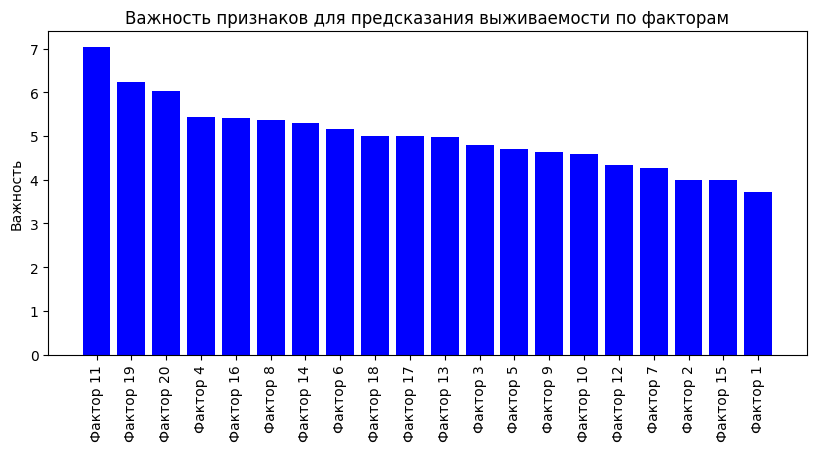

In [8]:
mofa_metrics = regression_pipeline_gdsc_cv(train_mofa, *pipeline_args_cv, mofa_dataset=mofa_data)
m_f_mofa, r_f_mofa = mofa_metrics.values()

### MCCA

,"MAPE предсказания по факторам, %",MAPE предсказания по факторам
Разбиение 1,65.305464,1.300643
Разбиение 2,38.564186,0.916968
Разбиение 3,51.813207,1.015338
Разбиение 4,89.311423,1.163237
Разбиение 5,126.394117,1.131657
Разбиение 6,34.647309,1.211888
Разбиение 7,46.435590,1.094017
Разбиение 8,105.426974,1.207783
Разбиение 9,50.387491,1.304045
Разбиение 10,299.747385,1.186417


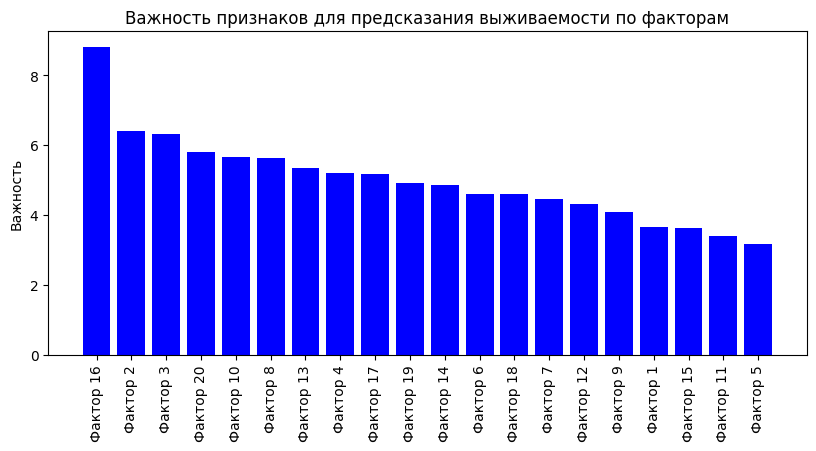

In [9]:
cca = MCCA(n_components=N_FACTORS, regs='oas', multiview_output=False)
mcca_metrics = regression_pipeline_gdsc_cv(cca, X_all_sep, *pipeline_args_cv[1:])
m_f_mcca, r_f_mcca = mcca_metrics.values()

### PCA

,"MAPE предсказания по факторам, %",MAPE предсказания по факторам
Разбиение 1,67.652752,1.288223
Разбиение 2,37.645515,0.922660
Разбиение 3,51.637564,1.059031
Разбиение 4,94.879095,1.150087
Разбиение 5,121.186580,1.069072
Разбиение 6,34.069845,1.171777
Разбиение 7,52.631358,1.223164
Разбиение 8,99.540522,1.211124
Разбиение 9,49.875833,1.158287
Разбиение 10,300.386723,1.164769


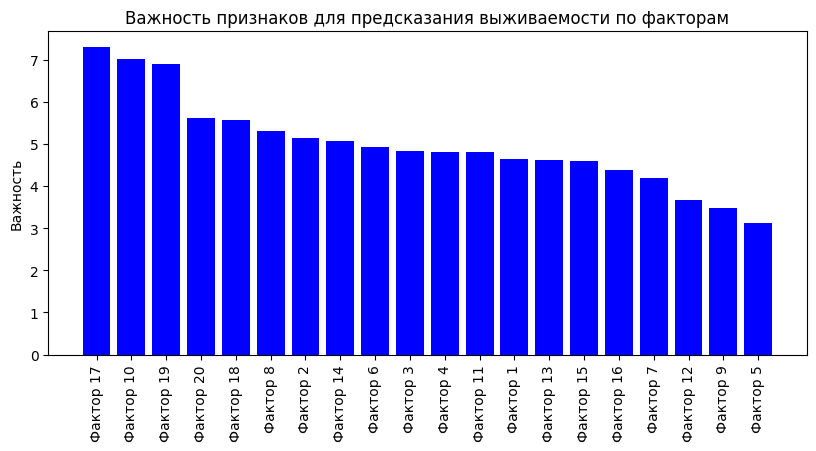

In [10]:

pca = PCA(n_components=N_FACTORS)
pca_metrics = regression_pipeline_gdsc_cv(pca, *pipeline_args_cv)
m_f_pca, r_f_pca = pca_metrics.values()

### UMAP

,"MAPE предсказания по факторам, %",MAPE предсказания по факторам
Разбиение 1,73.551004,1.312486
Разбиение 2,38.945199,0.910741
Разбиение 3,60.793091,1.205757
Разбиение 4,105.564005,1.313580
Разбиение 5,156.591425,1.256532
Разбиение 6,32.114475,1.209380
Разбиение 7,52.503254,1.201702
Разбиение 8,121.921642,1.399284
Разбиение 9,49.660980,1.291430
Разбиение 10,335.566270,1.214081


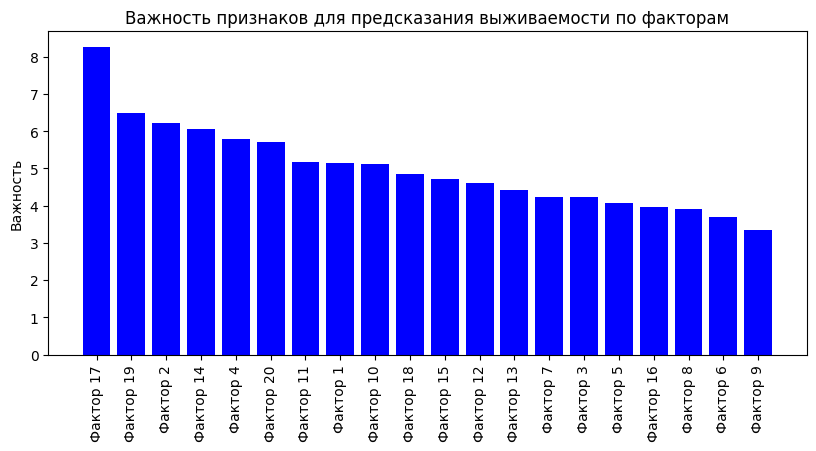

In [11]:
umap_reducer = umap.UMAP(n_components=N_FACTORS, random_state=RANDOM_STATE)
umap_metrics = regression_pipeline_gdsc_cv(umap_reducer, *pipeline_args_cv)

m_f_umap, r_f_umap = umap_metrics.values()

### Base Autoencoder

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lisabeth-shevtsova (liza-i-pivko). Use `wandb login --relogin` to force relogin


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


,"MAPE предсказания по факторам, %",MAPE предсказания по факторам
Разбиение 1,69.547691,1.352297
Разбиение 2,38.424909,0.941464
Разбиение 3,56.706017,1.087112
Разбиение 4,102.923356,1.214856
Разбиение 5,141.649271,1.135801
Разбиение 6,32.867099,1.172404
Разбиение 7,52.703676,1.159781
Разбиение 8,124.124108,1.348939
Разбиение 9,50.426311,1.184821
Разбиение 10,334.359747,1.188695


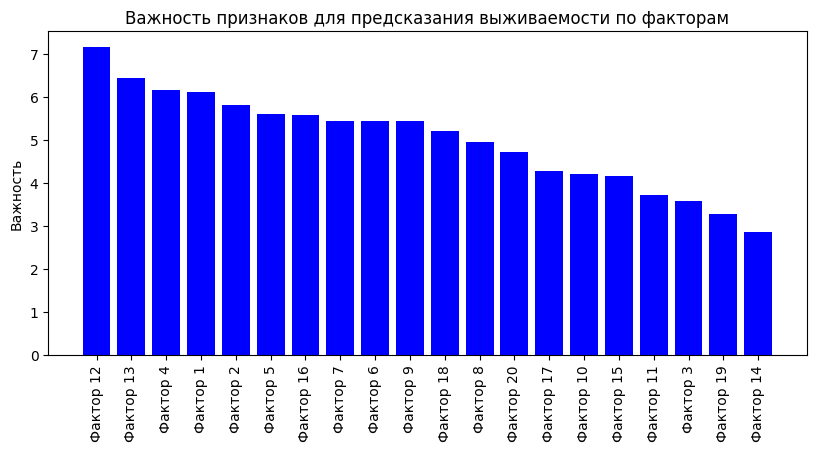

In [12]:
base_auto_metrics = regression_pipeline_gdsc_cv(EncoderPipeline, X_all_sep, *pipeline_args_cv[1:])

m_f_base_auto, r_f_base_auto = base_auto_metrics.values()

### Triple Autoencoder

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


,"MAPE предсказания по факторам, %",MAPE предсказания по факторам
Разбиение 1,73.654184,1.580289
Разбиение 2,42.204079,1.389388
Разбиение 3,67.213548,1.142393
Разбиение 4,76.253674,1.203732
Разбиение 5,144.901652,1.161785
Разбиение 6,36.954867,1.091552
Разбиение 7,51.276926,1.137101
Разбиение 8,93.307751,1.327109
Разбиение 9,77.392418,1.454903
Разбиение 10,324.471417,1.150845


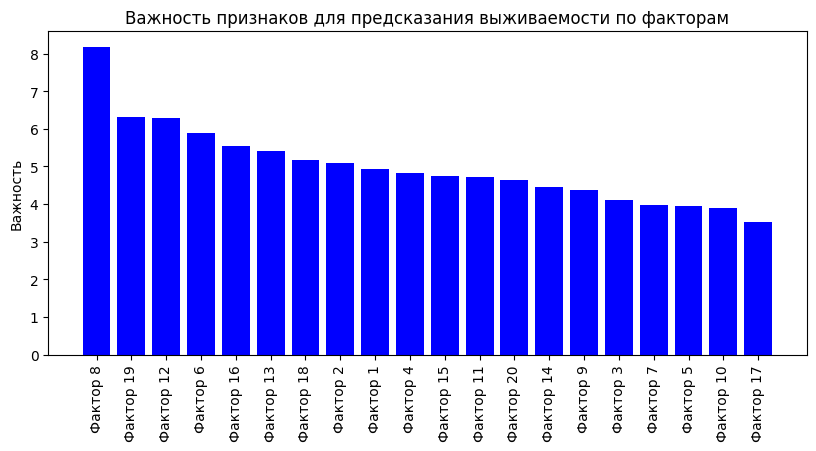

In [13]:
triple_auto_metrics = regression_pipeline_gdsc_cv(EncoderPipeline, X_all_sep, *pipeline_args_cv[1:], base_encoder=False)

m_f_triple_auto, r_f_triple_auto = triple_auto_metrics.values()

### Регрессия, результаты:

In [14]:
regr_results = pd.DataFrame({
    'MAPE factors, %': [m_f_base, m_f_pca, m_f_umap, m_f_mofa, m_f_mcca, m_f_base_auto, m_f_triple_auto],
    'RMSE factors, %': [r_f_base, r_f_pca, r_f_umap, r_f_mofa, r_f_mcca, r_f_base_auto, r_f_triple_auto],
}, index=['No factorization', 'PCA', 'UMAP', 'MOFA', 'MCCA', 'Base Autoencoder', 'Triple Autoencoder'])

regr_results['Method Average'] = regr_results.mean(axis=1)
column_means = regr_results.iloc[:, :-1].mean(axis=0)
regr_results.loc['All Methods Average'] = column_means.tolist() + ['-']

regr_results

,"MAPE factors, %","RMSE factors, %",Method Average
No factorization,85.070890,1.057741,43.064316
PCA,90.950579,1.141820,46.046199
UMAP,102.721135,1.231497,51.976316
MOFA,95.004440,1.155773,48.080106
MCCA,90.803315,1.153199,45.978257
Base Autoencoder,100.373218,1.178617,50.775918
Triple Autoencoder,98.763052,1.263910,50.013481
All Methods Average,94.812375,1.168937,-


### *В задаче предсказания ic50 по факторам, используя CatboostRegressor, лучше всего оказалась MOFA*